#### Clustering sobre informes medicos
A continuacion se trabajara sobre un corpus compuesto por informes de diagnostico medico, correspondiente a visitas medicas.

Cada informe será tratado como un documento, luego se trabaja con la oracion como unidad minima.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import random
import sklearn.manifold
import spacy

from collections import defaultdict, Counter
from nltk.cluster import kmeans, cosine_distance
from sklearn.feature_extraction import DictVectorizer



In [ ]:
spacy.cli.download('es_core_news_md')

In [2]:
nlp = spacy.load('es_core_news_md')

path = './corpus/meddoprof-training/meddoprof-complementary-entities'

files = os.listdir(path)
docs = []
for fi in files:
    f = open(f'{path}/{fi}')
    docs.append(nlp(f.read()))
    f.close()

In [3]:
words = []
words_lemma = []
sentences = []
for doc in docs:
    for s in doc.sents:
        # Si quiero ignorar oraciones este es el lugar (se hará mas adelante).
        if(len(s) >= 0):
            sentences.append(s)
            for token in sentences[-1]:
                # itero sobre los token de la ultima oracion agregada.
                if token.is_alpha:
                    # cada elemento de words es: (token, doc donde se encuentra, numero de oración)
                    words.append((token, doc, len(s)-1))
                    words_lemma.append(token.lemma_)

counts = Counter(words_lemma)

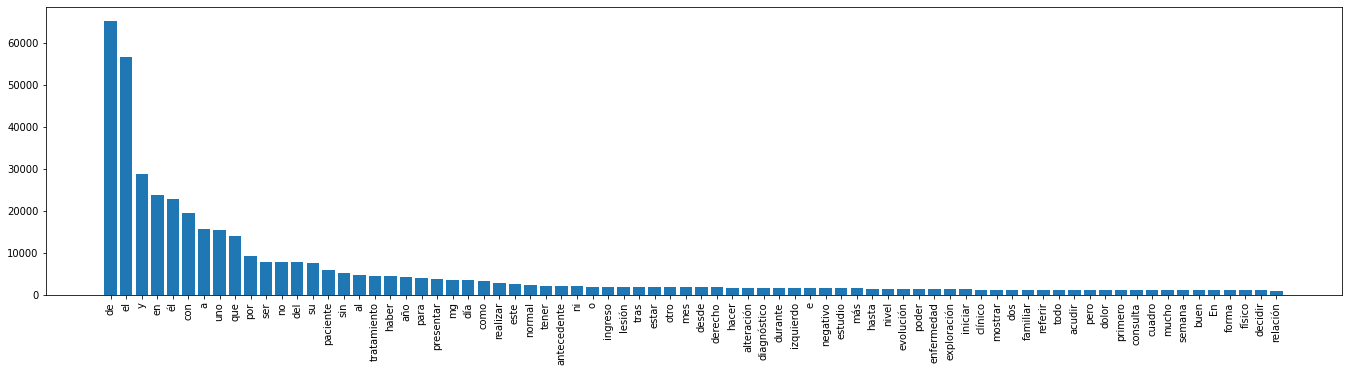

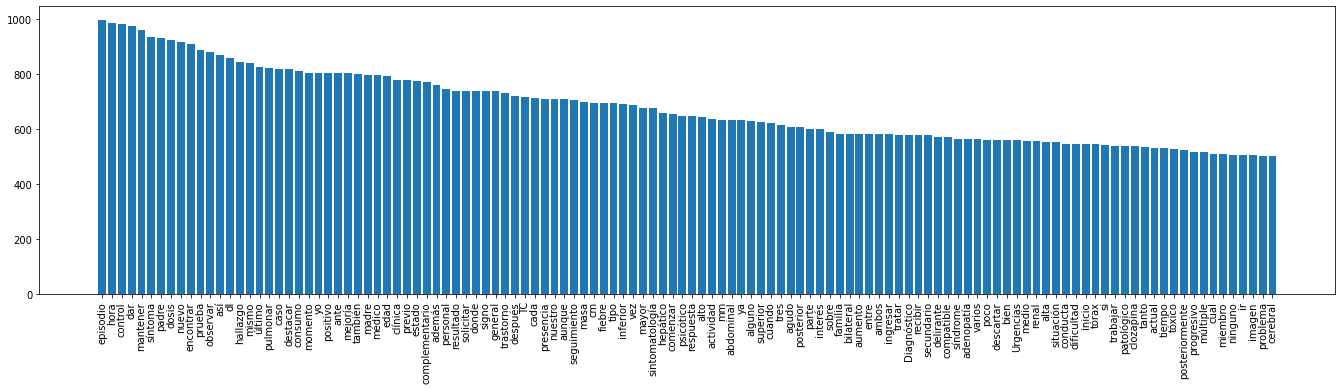

In [4]:
# se realiza un grafico de barras con las palabras mas frecuentes (normalizadas).
fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
ax.bar([x for x, y in counts.most_common() if y > 1000], [y for x, y in counts.most_common() if y > 1000])
plt.xticks(rotation='vertical')
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
ax.bar([x for x, y in counts.most_common() if 1000 > y > 500], [y for x, y in counts.most_common() if 1000 > y > 500])
plt.xticks(rotation='vertical')
plt.show()

Con esto vemos que palabras muy frecuentes son: paciente, tratamiento, presentar, realizar, antecedentes, ingreso, lesión, diagnostico, estudio, evolucion, enfermedad.
Son palabras tipicas en todo diagnostico que describen como se compone una consulta medica.
Luego le siguen otras palabras más relacionadas a las caracteristicas de un diagnostico.
Se evaluará si es posible clusterizar estas caracteristicas con los tratamientos y/o diagnosticos.

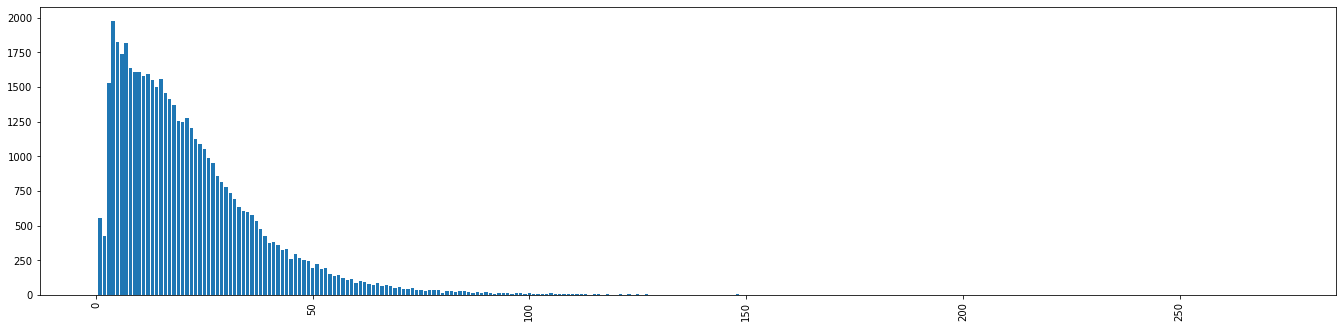

Total de oraciones: 		50937
Con menos de 10 palabras: 	25.73%


In [5]:
# Analizamos el largo de las oraciones.

largos = defaultdict(int)
for s in sentences:
    largos[len(s)] += 1

fig = plt.figure()
ax = fig.add_axes([0,0,3,1])
# largos

ax.bar([x for x, y in largos.items()], [y for x, y in largos.items()])
plt.xticks(rotation='vertical')
plt.show()

print(f'\
Total de oraciones: \t\t{len(sentences)}\n\
Con menos de 10 palabras: \t{len([s for s in sentences if len(s) < 10]) / len(sentences) * 100 :.2f}%')

Como se puede observar, la distribución del largo de las oraciones es similar a una exponencial, por esto no podemos exagerar al descartar oraciones cortas ya que descartariamos gran parte de nuestros dato.
Al ignorar oraciones menores a 10 palabras descartamos un 25% de ellas.

In [ ]:
# descartamos oraciones < 10
words = []
words_lemma = []
sentences = []
for doc in docs:
    for s in doc.sents:
        # Si quiero ignorar oraciones este es el lugar (se hará mas adelante).
        if(len(s) < 10):
            continue
        
        sentences.append(s)
        for token in sentences[-1]:
            # itero sobre los token de la ultima oracion agregada.
            if token.is_alpha:
                # cada elemento de words es: (token, doc donde se encuentra, numero de oración)
                words.append((token, doc, len(s)-1))
                words_lemma.append(token.lemma_)

counts = Counter(words_lemma)

In [ ]:
# sum([n for c, n in counts.items() if n > 20]) / len(words_lemma)

print(len([c for c, n in counts.items() if n <= 1]))
print(len([c for c, n in counts.items() if n  > 1]))
print(len(counts.items()))

# random.choices(sentences, k=15)

In [ ]:
# comenzamos con los diccionarios de cada palabra (y un diccionario con todas las palabras).

def create_dicc(prev = 0, post = 0, threshold_w = 50, threshold_c = 10):
    """
    Retorna un defaultdict donde features son defaultdict(int)
    prev:         numero de palabras previas para el entorno.
    post:         numero de palabras posteriores para el entorno.
    threshold_w:  cantidad de repeticiones de una palabra para ser evaluada (un loop). NO debe ser menor a 50 aprox
    threshold_c:  cantidad de apariciones de una palabra para no ser ignorada al evaluar el entorno.
    """
    dicc = defaultdict(lambda: defaultdict(int))
#     for word, doc, sent in words:
    for sent in sentences:
        for word in sent:
            w = word.lemma_
            # obtengo las features de la palabra
            if not word.is_alpha or str.isdigit(w) or counts[w] < threshold_w:
                # si no es palabra o ocurre pocas veces ignoro.
                continue

            features = dicc[w]
            # obtengo su .pos_ y dep_, y los cuento.
            features[f"POS_{word.pos_}"] += 1
            features[f"DEP_{word.dep_}"] += 1
            # obtengo tags morfologicos
            tags = str(word.morph).split('|')
            for tag in tags:
                features[tag] += 1

            # trabajo con las palabra del contexto de la oracion.
            for index in range(max(word.i - sent.start - prev, 0), word.i - sent.start):
                # itera: word.i -prev, word.i -(prev-1), word.i -(prev-2), ..., word.i -1.
                context_izq = sent[index]
                c_izq = context_izq.lemma_
                if context_izq.is_alpha and counts[c_izq] > threshold_c:
                    if str.isdigit(c_izq):
                        c_izq = "NUM_"
                    features[c_izq] += 1

            for index in range(word.i - sent.start + 1, min(len(sent), word.i - sent.start + post + 1)):
                # itera: word.i +1, word.i +2, ..., word.i +post.
                context_der = sent[index]
                c_der = context_der.lemma_
                if context_der.is_alpha and counts[c_der] > threshold_c:
                    if str.isdigit(c_der):
                        c_der = "NUM__"
                    features[c_der] += 1

            tripla = f"TRIPLA__{w}__{word.lemma_}__{word.dep_}__{word.head.lemma_}"
            features[tripla] += 1

            dicc[w] = features

    return dicc

# dicc_0_0 = create_dicc(0, 0)
# dicc_1_1 = create_dicc(1, 1)
# dicc_2_2 = create_dicc(2, 2)
dicc_5_5 = create_dicc(5, 5, threshold_c=50)
# dicc_7_7 = create_dicc(2, 2, threshold_c=50)


In [ ]:
# para trabajar con DictVectorizer debo tener un array de dicts (features)
# convierto los features en un array
def dict_to_array_features(dicc):
    features = []
    key_words = {}
    new_words = []   # aca van las palabras en el mismo orden que key_words.
    wid = 0
    for d in dicc:
        if len(d) > 0:
            key_words[d] = wid
            wid += 1
            features.append(dict(dicc[d]))
            new_words.append(d)
    return features, key_words, new_words

def matrix_normalizer(features):
    # vectorizo y obtengo matriz
    v = DictVectorizer(sparse=False)
    matrix = v.fit_transform(features)

    # normalizo matriz
    matrix_normed = matrix / matrix.max(axis=0)

    # varianza
    variances = np.square(matrix_normed).mean(axis=0) - np.square(matrix_normed.mean(axis=0))

    # ¿red matriz?
    threshold_v = 0.001
    red_matrix = np.delete(matrix_normed, np.where(variances < threshold_v), axis=1)
    
    return red_matrix

def dimension_reduction(red_matrix):
    # reduzco la dimencionalidad?
    tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
    matrix_dicc2d = tsne.fit_transform(red_matrix)
    return matrix_dicc2d



In [ ]:
# features, key_words, new_words = dict_to_array_features(dicc_0_0)
# features, key_words, new_words = dict_to_array_features(dicc_1_1)
# features, key_words, new_words = dict_to_array_features(dicc_2_2)
features, key_words, new_words = dict_to_array_features(dicc_5_5)
# Se cumple: dicc_0_0[new_words[3]] == features[3]
# y new_words_0_0 == new_words_1_1

red_matrix = matrix_normalizer(features)

matrix_dicc2d = dimension_reduction(red_matrix)

In [6]:
# dump and load data
def dump_files(dicc, features, key_words, red_matrix, matrix_dicc2d, new_words, prev, post):
    filename = f"trained/{prev}_{post}_med_dicc.pickle"
    fileObj = open(filename, 'wb')
    pickle.dump(dict(dicc), fileObj)
    fileObj.close()

    # guardo features y key_words
    filename = f"trained/{prev}_{post}_med_cleandicc.pickle"
    fileObj = open(filename, 'wb')
    pickle.dump(features, fileObj)
    fileObj.close()

    filename = f"trained/{prev}_{post}_med_keys.pickle"
    fileObj = open(filename, 'wb')
    pickle.dump(key_words, fileObj)
    fileObj.close()

    # guardo matriz
    filename = f"trained/{prev}_{post}_med_matrix.pickle"
    fileObj = open(filename, 'wb')
    pickle.dump(red_matrix, fileObj)
    fileObj.close()

    # guardo matriz reducida
    filename = f"trained/{prev}_{post}_med_matrix2d.pickle"
    fileObj = open(filename, 'wb')
    pickle.dump(matrix_dicc2d, fileObj)
    fileObj.close()

    filename = f"trained/{prev}_{post}_med_words.pickle"
    fileObj = open(filename, 'wb')
    pickle.dump(new_words, fileObj)
    fileObj.close()


def load_files(prev, post):
    # cargo dicc del archivo
    filename = f"trained/{prev}_{post}_med_dicc.pickle"
    with open(filename, 'rb') as f:
        dicc = pickle.load(f)
    # cargo los features
    filename = f"trained/{prev}_{post}_med_cleandicc.pickle"
    with open(filename, 'rb') as f:
        features = pickle.load(f)

    filename = f"trained/{prev}_{post}_med_keys.pickle"
    with open(filename, 'rb') as f:
        key_words = pickle.load(f)
    # cargo
    filename = f"trained/{prev}_{post}_med_matrix.pickle"
    with open(filename, 'rb') as f:
        red_matrix = pickle.load(f)
    # cargo
    filename = f"trained/{prev}_{post}_med_matrix2d.pickle"
    with open(filename, 'rb') as f:
        matrix_dicc2d = pickle.load(f)
    # words
    filename = f"trained/{prev}_{post}_med_words.pickle"
    with open(filename, 'rb') as f:
        new_words = pickle.load(f)
    return dicc, features, key_words, red_matrix, matrix_dicc2d, new_words


In [ ]:
# dejar la siguiente linea comentada para no mandar moco.
# dump_files(dicc_0_0, features, key_words, red_matrix, matrix_dicc2d, new_words, 0, 0)
# dump_files(dicc_1_1, features, key_words, red_matrix, matrix_dicc2d, new_words, 1, 1)
# dump_files(dicc_2_2, features, key_words, red_matrix, matrix_dicc2d, new_words, 2, 2)
dump_files(dicc_5_5, features, key_words, red_matrix, matrix_dicc2d, new_words, 5, 5)


In [ ]:
# Load files.
# dicc_0_0, features_0_0, key_words_0_0, red_matrix_0_0, matrix_dicc2d_0_0, new_words_0_0 = load_files(0, 0)
# dicc_1_1, features_1_1, key_words_1_1, red_matrix_1_1, matrix_dicc2d_1_1, new_words_1_1 = load_files(1, 1)
# dicc_2_2, features_2_2, key_words_2_2, red_matrix_2_2, matrix_dicc2d_2_2, new_words_2_2 = load_files(2, 2)
dicc_5_5, features_5_5, key_words_5_5, red_matrix_5_5, matrix_dicc2d_5_5, new_words_5_5 = load_files(5, 5)


In [ ]:
# ¿creo el grafico?
def distribution_graph(matrix_dicc2d, key_words):
    pointsspacy = pd.DataFrame(
        [
            (word, coords[0], coords[1])
            for word, coords in [
                (word, matrix_dicc2d[key_words[word]])
                for word in key_words
            ]
        ],
        columns=["word", "x", "y"]
    )

    pointsspacy.plot.scatter("x", "y", s=10, figsize=(20, 12))
    
# distribution_graph(matrix_dicc2d_0_0, key_words_0_0)
# distribution_graph(matrix_dicc2d_1_1, key_words_1_1)
# distribution_graph(matrix_dicc2d_2_2, key_words_2_2)
distribution_graph(matrix_dicc2d_5_5, key_words_5_5)


In [ ]:
def clustering(k, red_matrix):
    clusterer = kmeans.KMeansClusterer(k, cosine_distance, avoid_empty_clusters=True)
    clusters = clusterer.cluster(red_matrix, True)
    return clusters

# parametro: numero de cluster a definir.
# c20_0_0 =  clustering(20, red_matrix_0_0)
# c20_1_1 =  clustering(20, red_matrix_1_1)
# c20_2_2 =  clustering(20, red_matrix_2_2)
# c20_5_5 =  clustering(20, red_matrix_5_5)
c30_5_5 =  clustering(30, red_matrix_5_5)


In [7]:
# dump and load clusters.
def dump_clusters(prev, post, l):
    for label, clust in l:
        filename = f"trained/{prev}_{post}_med_cluster_{label}.pickle"
        fileObj = open(filename, 'wb')
        pickle.dump(clust, fileObj)
        fileObj.close()

def load_clusters(prev, post, label):
    filename = f"trained/{prev}_{post}_med_cluster_{label}.pickle"
    with open(filename, 'rb') as f:
        clusters = pickle.load(f)
    return clusters


In [ ]:
# dump_clusters(0, 0, [('20', c20), ('40', c40)])
# dump_clusters(0, 0, [('20', c20_0_0)])
# dump_clusters(1, 1, [('20', c20_1_1)])
# dump_clusters(2, 2, [('20', c20_2_2)])
# dump_clusters(5, 5, [('20', c20_5_5)])
# dump_clusters(5, 5, [('30', c30_5_5)])


In [8]:
c20_0_0 = load_clusters(0, 0, '20')
c20_1_1 = load_clusters(1, 1, '20')
c20_2_2 = load_clusters(2, 2, '20')
c20_5_5 = load_clusters(5, 5, '20')
c30_5_5 = load_clusters(5, 5, '30')


In [9]:
# Load files.
_, _, key_words_0_0, _, matrix_dicc2d_0_0, new_words_0_0 = load_files(0, 0)
_, _, key_words_1_1, _, matrix_dicc2d_1_1, new_words_1_1 = load_files(1, 1)
_, _, key_words_2_2, _, matrix_dicc2d_2_2, new_words_2_2 = load_files(2, 2)
_, _, key_words_5_5, _, matrix_dicc2d_5_5, new_words_5_5 = load_files(5, 5)


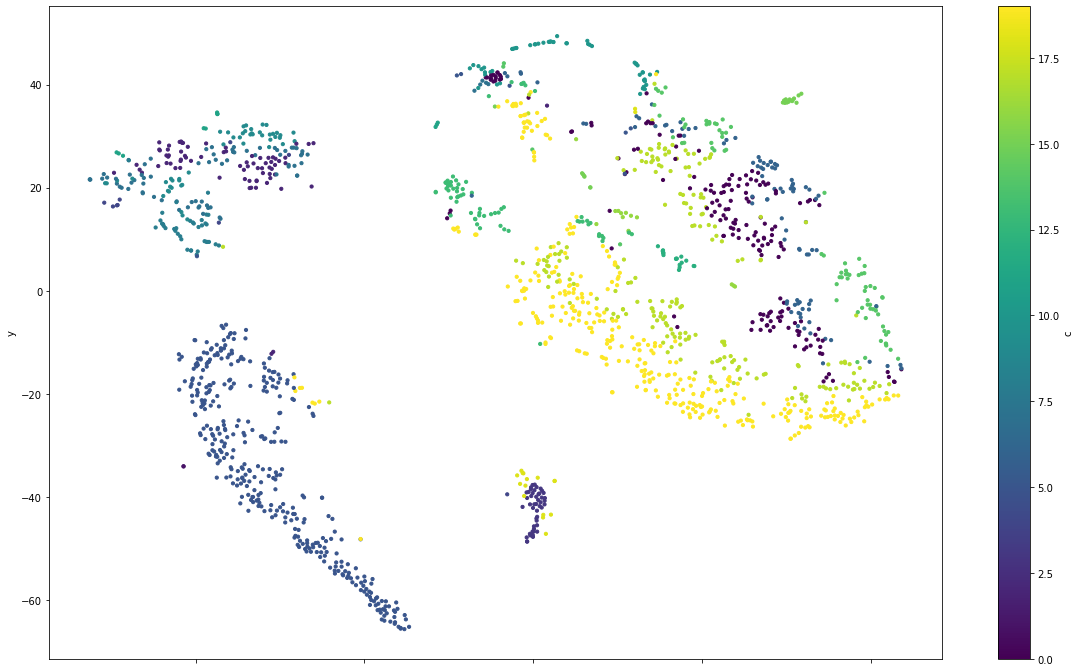

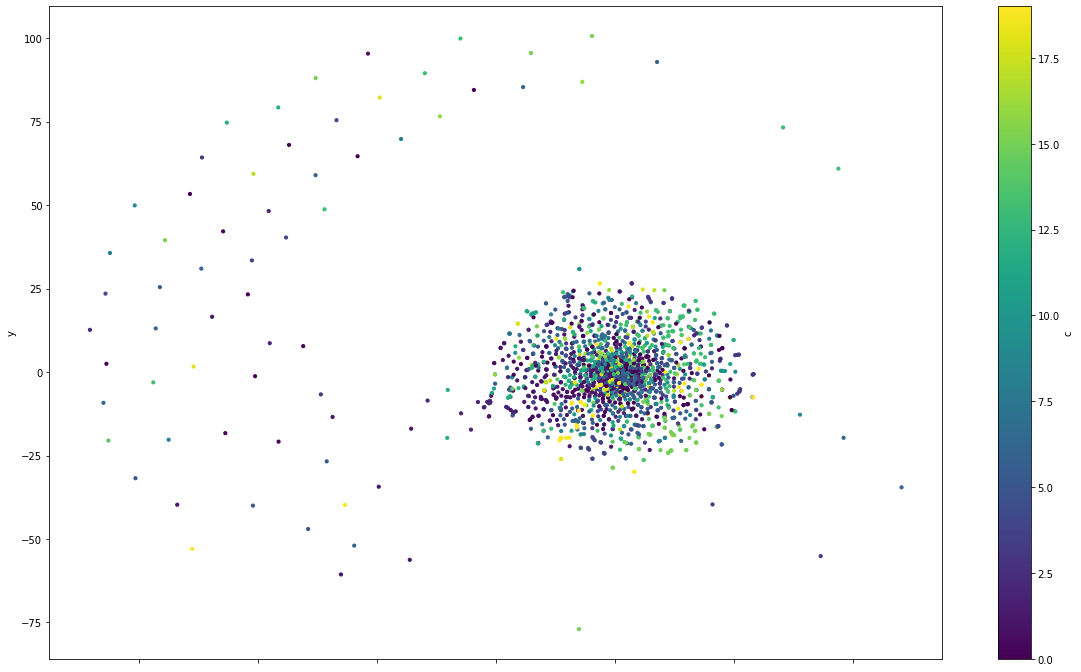

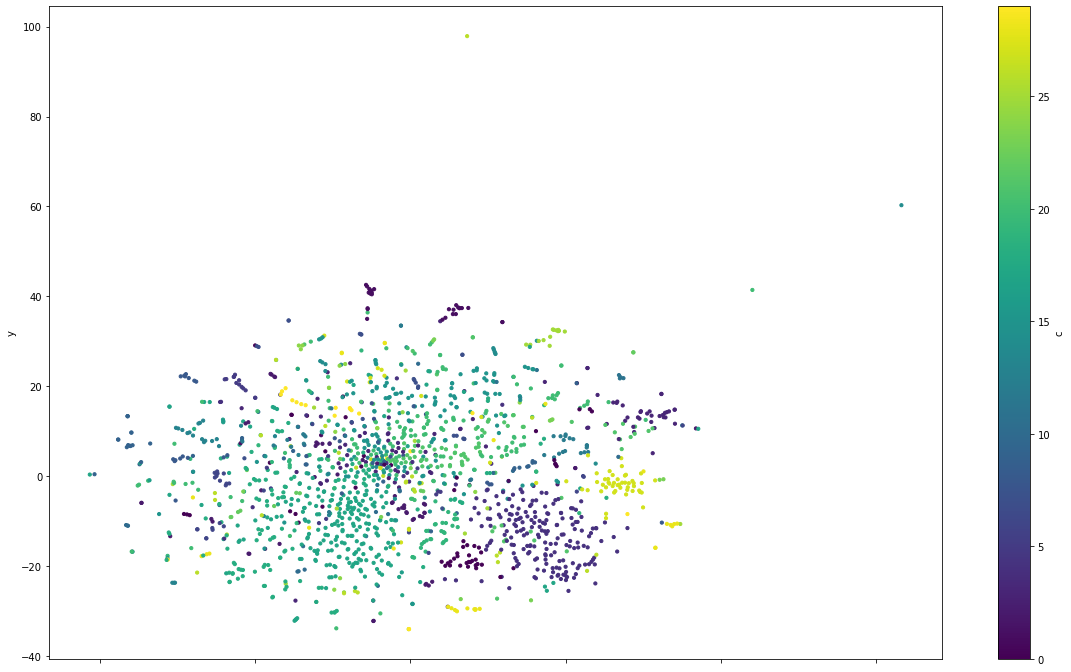

In [10]:
def distribution_graph_color(clusters, key_words, matrix_dicc2d):
    pointscluster = pd.DataFrame(
        [
            (word, coords[0], coords[1], cluster)
            for word, coords, cluster in [
                (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
                for word in key_words
            ]
        ],
        columns=["word", "x", "y", "c"]
    )
    pointscluster.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=10, figsize=(20, 12))

    
distribution_graph_color(c20_0_0, key_words_0_0, matrix_dicc2d_0_0)
# distribution_graph_color(c20_1_1, key_words_1_1, matrix_dicc2d_1_1)
distribution_graph_color(c20_2_2, key_words_2_2, matrix_dicc2d_2_2)
# distribution_graph_color(c20_5_5, key_words_5_5, matrix_dicc2d_5_5)
distribution_graph_color(c30_5_5, key_words_5_5, matrix_dicc2d_5_5)


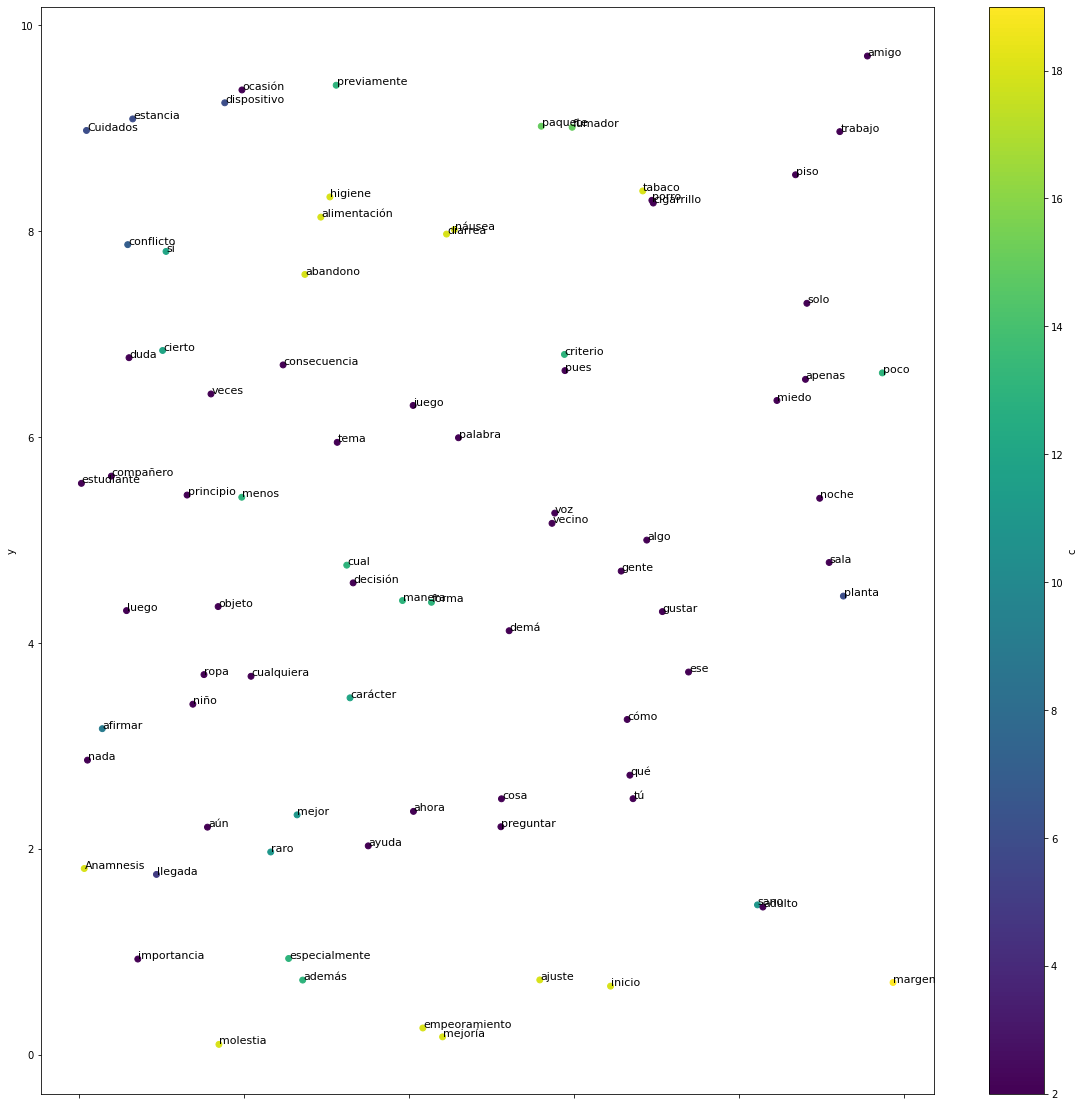

In [11]:
def plot_region_cluster(clusters, key_words, matrix_dicc2d, x_bounds, y_bounds):
    pointscluster = pd.DataFrame(
        [
            (word, coords[0], coords[1], cluster)
            for word, coords, cluster in [
                (word, matrix_dicc2d[key_words[word]], clusters[key_words[word]])
                for word in key_words
            ]
        ],
        columns=["word", "x", "y", "c"]
    )
    
    slice = pointscluster[
        (x_bounds[0] <= pointscluster.x) &
        (pointscluster.x <= x_bounds[1]) & 
        (y_bounds[0] <= pointscluster.y) &
        (pointscluster.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter(x='x', y='y', c='c', cmap='viridis', s=35, figsize=(20, 20))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)


# plot_region_cluster(c20_0_0, key_words_0_0, matrix_dicc2d_0_0, x_bounds=(-5, 5), y_bounds=(-50, -30))
# plot_region_cluster(c20_1_1, key_words_1_1, matrix_dicc2d_1_1, x_bounds=(-15, -5), y_bounds=(5, 15))
# plot_region_cluster(c20_2_2, key_words_2_2, matrix_dicc2d_2_2, x_bounds=(-5, 5), y_bounds=(-10, 0))
plot_region_cluster(c20_5_5, key_words_5_5, matrix_dicc2d_5_5, x_bounds=(0, 10), y_bounds=(0, 10))


In [16]:
def print_clusters(clusters, key_words, new_words):
    l = []
    for i in range(max(clusters) + 1):
        l.append([])
    
    for word in new_words:
        l[clusters[key_words[word]]].append(word)
    k = 0
    for c in l:
        print(f'\n Cluster: {k:}- Total words: {len(c)}')
        print(f'- {c}.')
        k += 1

print('20 clusters sin evaluar el entorno de cada palabra.')
print_clusters(c20_0_0, key_words_0_0, new_words_0_0)
print('###########################################\n###########################################')

# print('\n20 clusters tomando 1 palabra a la izquierda y 1 a la derecha como entorno, donde cada palabra del entorno se repite al menos 10 veces en el corpus.')
# print_clusters(c20_1_1, key_words_1_1, new_words_1_1)
# print('###########################################\n###########################################')

# print('\n20 clusters tomando 2 palabra a la izquierda y 2 a la derecha como entorno, donde cada palabra del entorno se repite al menos 10 veces en el corpus.')
# print_clusters(c20_2_2, key_words_2_2, new_words_2_2)
# print('###########################################\n###########################################')

# print('\n20 clusters tomando 5 palabra a la izquierda y 5 a la derecha como entorno, donde cada palabra del entorno se repite al menos 50 veces en el corpus.')
# print_clusters(c20_5_5, key_words_5_5, new_words_5_5)
# print('###########################################\n###########################################')

# print('\n30 clusters tomando 5 palabra a la izquierda y 5 a la derecha como entorno, donde cada palabra del entorno se repite al menos 50 veces en el corpus.')
# print_clusters(c30_5_5, key_words_5_5, new_words_5_5)


20 clusters sin evaluar el entorno de cada palabra.

 Cluster: 0- Total words: 176
- ['uno', 'familia', 'gente', 'problema', 'animal', 'compañero', 'cabeza', 'demá', 'poco', 'pensamiento', 'sueño', 'aquel', 'futuro', 'peso', 'niño', 'daño', 'serie', 'repetición', 'mundo', 'voz', 'nivel', 'Mental', 'grupo', 'ánimo', 'enfermedad', 'ensayo', 'señal', 'recaída', 'estrés', 'evolución', 'progresivamente', 'reposo', 'masa', 'crecimiento', 'aproximadamente', 'miembro', 'tumoración', 'tumor', 'cava', 'tamaño', 'cadena', 'tercio', 'Anatomía', 'riesgo', 'proceso', 'soporte', 'tratamiento', 'trombosis', 'durante', 'Durante', 'Oncología', 'Médica', 'quimioterapia', 'cisplatino', 'pulmón', 'captación', 'lesión', 'Ante', 'arteria', 'cadera', 'adenocarcinoma', 'hacia', 'terapia', 'zona', 'hez', 'sangrado', 'articulación', 'característica', 'célula', 'hueso', 'cirugía', 'mano', 'PET', 'carácter', 'patología', 'ritmo', 'infección', 'completamente', 'presentación', 'fármaco', 'cannabis', 'dependencia', '